In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd /raid/home/myang349/recsys-filterbubbles/

/raid/home/myang349/recsys-filterbubbles


# Imports

In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim
from os import listdir
from os.path import isfile, join
from tracin.tracin import (
    save_tracin_checkpoint,
    load_tracin_checkpoint,
    calculate_tracin_influence,
)
import pandas as pd
from LSTM_clean.utils import filter_and_split_data, sequence_generator, load_community_dict, get_communities 
from LSTM_clean.model import LSTM 
from collections import Counter
import numpy as np
import pickle
from collections import defaultdict
import copy
from torch.optim import SGD
from lstm_wrapper import train_model, get_topk_predictions
from dataclasses import dataclass
import matplotlib.pyplot as plt
from copy import deepcopy
import math

# Loading Data

In [5]:
# Data Location
# Use SAVE_PREFIX to mark different datasets
SAVE_PREFIX = "104k"
SAVE_FOLDER = "/raid/home/myang349/recsys-filterbubbles/data/twitch_sequence/"
SAVE_TRAIN_NAME = SAVE_PREFIX + "train.data"
SAVE_VALID_NAME = SAVE_PREFIX + "valid.data"
SAVE_TEST_NAME = SAVE_PREFIX + "test.data"
SAVE_COMMUNITY_NAME = SAVE_PREFIX + "lstm_idx_communities.data"

In [6]:
train_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TRAIN_NAME), allow_pickle=True)
valid_data = np.load(os.path.join(SAVE_FOLDER, SAVE_VALID_NAME), allow_pickle=True)
test_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TEST_NAME), allow_pickle=True)

# Shannon Index

In [ ]:
hm = Counter(community_dict.values())

In [ ]:
hm

Counter({13: 746,
         8: 486,
         9: 217,
         14: 198,
         2: 151,
         7: 222,
         6: 191,
         4: 108,
         11: 342,
         3: 57,
         0: 286,
         10: 71,
         1: 67,
         15: 25,
         5: 94,
         12: 50})

In [265]:
def shannon_index(c1, community_dict):
    richness = len(set(community_dict.values()))
    comm_hm = Counter(c1)
    ans = 0
    for i in range(richness):
        if i in comm_hm:
            p = comm_hm[i] / len(c1)
            ans += p * math.log(p)
        else:
            ans += 0
    return -ans

In [266]:
nums = [1,2,3,4,5]

In [267]:
shannon_index(nums, community_dict)

1.6094379124341005

In [270]:
shannon_index([1,2,3,3,5], community_dict)

1.3321790402101223

In [294]:
def simpson_index(communities, community_dict):
    """Gives more weight to dominate topics
    
    The original Simpson index λ equals the probability that two entities taken 
    at random from the dataset of interest (with replacement) represent the same type."""
    richness = len(set(community_dict.values()))
    hm_communities = Counter(communities)
    ans = 0
    for label in range(richness):
        if label in hm_communities:
            p = hm_communities[label] / len(communities)
            ans += p*p
        else:
            ans += 0
    return 1 - ans
                   
                   

In [299]:
simpson_index([1,2,3,4,5, 6], community_dict)

0.8333333333333333

In [300]:
simpson_index([5,5,5,5,1,2], community_dict)

0.5

In [301]:
simpson_index([5,5,3,3,3,3], community_dict)

0.4444444444444444

In [303]:
simpson_index([1,1,1,1,3], community_dict)

0.31999999999999984

In [305]:
simpson_index([1,1,1,1,5], community_dict)

0.31999999999999984

# Loading model

In [7]:
# model = train_model()

# Init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
model = LSTM(input_size=128, output_size=3312, hidden_dim=64, n_layers=1, device=device) 
model.LSTM.flatten_parameters()
optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)

# Loading
model, _, epoch, loss = load_tracin_checkpoint(model, optimizer, "/raid/home/myang349/recsys-filterbubbles/checkpoints/lstm_checkpoint_epoch600.pt")

Device is cuda


In [8]:
model.to(device)

LSTM(
  (item_emb): Embedding(3312, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3312, bias=True)
)

## Verify the recall

In [9]:
# Generate sequences and gt
sequences = [pt[0] for pt in valid_data]
# sequences = [list(reversed(pt[0]))[:10] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

In [10]:
# Generate predictions
predictions = get_topk_predictions(model, sequences, k=50)

In [11]:
assert len(sequences) == len(predictions)
hit = 0
total = 0
for i, val in enumerate(gt):
    if val in predictions[i][:10]:
        hit += 1
    total += 1  
hit/total

0.5059769615301022

## Computing community vectors

In [12]:
community_dict = load_community_dict(os.path.join(SAVE_FOLDER, SAVE_COMMUNITY_NAME))

## Converting prev and predictions to be equal length and in community embedding

In [86]:
LOOKBACK = 50
THRESHOLD = 0

In [87]:
# Alternate version where we just get the last lookback from prev
prev_comm = []
pred_comm = []

for i in range(len(sequences)):
    prev = list(reversed(sequences[i]))[:LOOKBACK]
    n = len([x for x in prev if x != 0 and x in community_dict])
    
    if n < THRESHOLD:
        continue
        
    pred = predictions[i][:n]
    prev_comm.append(get_communities(prev, community_dict))
    pred_comm.append(get_communities(pred, community_dict))
    
for i in range(len(prev_comm)):
    assert len(prev_comm[i]) ==len(pred_comm[i])
    assert THRESHOLD <= len(prev_comm[i]) <= LOOKBACK
    
print(len(sequences))
print(len(prev_comm))

9202
9202


# Analysis

In [131]:
prev_num_comm = 0
pred_num_comm = 0
n = len(prev_comm)
threshold = 0

for i in range(n):
    if len(prev_comm[i]) < threshold:
        assert False
    prev_num_comm += len(set(prev_comm[i]))
    pred_num_comm += len(set(pred_comm[i]))

In [89]:
prev_num_comm / n

2.457617909150185

In [90]:
pred_num_comm / n

3.613996957183221

In [91]:
community_counts = Counter(community_dict.values())

In [153]:
def plot_counts(counts: dict[str, int], title='bla', xlabel='something', ylabel='count') -> plt.Figure:
    """Plots a histogram from dict"""
    fig = plt.figure()

    # Creating the barplot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
#     return fig

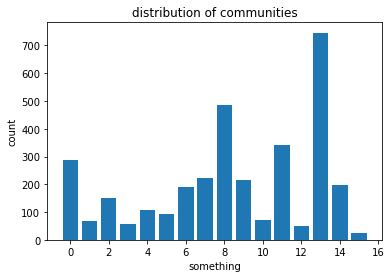

In [154]:
plot_counts(community_counts, 'distribution of communities')

## Distributions

In [99]:
watch_history_length_counts = Counter(len(x) for x in prev_comm)
counts = {k: watch_history_length_counts[k] for k in sorted(watch_history_length_counts)}
assert sum(counts.values()) == n

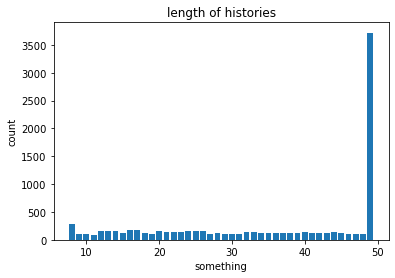

In [155]:
plot_counts(counts, 'length of histories')

In [132]:
prev_unique_comms_by_length = defaultdict(list)
pred_unique_comms_by_length = defaultdict(list)

In [133]:
# Making sure distribution is the same
assert Counter(len(x) for x in pred_comm) == Counter(len(x) for x in prev_comm)

### This experiment is doomed

In [137]:
# for i in range(len(prev_comm)):
#     c1, c2 = prev_comm[i], pred_comm[i]
#     nc1 = len(prev_comm[i])
    
#     prev_unique_comms_by_length[nc1].append(len(set(c1)))
#     pred_unique_comms_by_length[nc1].append(len(set(c2)))

    
# # Convert to floats
# def to_float(hm):
#     hm = deepcopy(hm)
#     for k, v in hm.items():
#         hm[k] = sum(v) / len(v)
#     return hm
    
        
# hm1 = to_float(prev_unique_comms_by_length)
# hm2 = to_float(pred_unique_comms_by_length)

### Plotting the percentage of points that are less diverse, by length

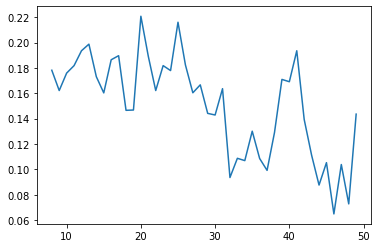

In [184]:
# line plot
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(hm.keys()), [hm[x] for x in sorted(hm.keys())])

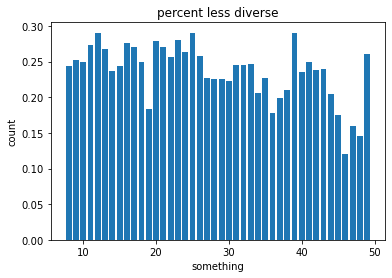

In [271]:
hm = defaultdict(int)
tot = defaultdict(int)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if len(set(c2)) < len(set(c1)):
    if shannon_index(c2, community_dict) < shannon_index(c1, community_dict):
        hm[len(c1)] += 1
    tot[len(c1)] += 1
    
for k in hm:
    hm[k] = hm[k] / tot[k]
plot_counts(hm, 'percent less diverse')

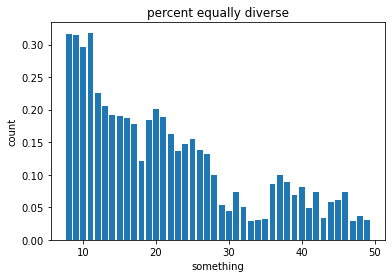

In [273]:
hm = defaultdict(int)
tot = defaultdict(int)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if len(set(c1)) == len(set(c2)):
    if shannon_index(c2, community_dict) == shannon_index(c1, community_dict):
        hm[len(c1)] += 1
    tot[len(c1)] += 1
    
for k in hm:
    hm[k] = hm[k] / tot[k]
plot_counts(hm, 'percent equally diverse')

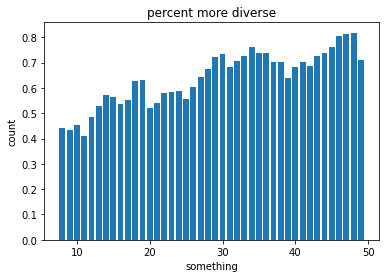

In [274]:
hm = defaultdict(int)
tot = defaultdict(int)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if len(set(c2)) > len(set(c1)):
    if shannon_index(c2, community_dict) > shannon_index(c1, community_dict):
        hm[len(c1)] += 1
    tot[len(c1)] += 1
    
for k in hm:
    hm[k] = hm[k] / tot[k]
plot_counts(hm, 'percent more diverse')

## Raw Diversity

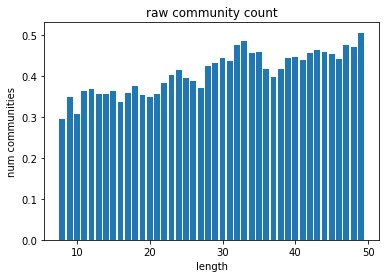

In [275]:
# prev_communities only
hm1 = defaultdict(list)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    hm1[len(c1)].append(len(set(c1)))

    
# Convert to percents
for k in hm1:
    hm1[k] = np.mean(hm1[k])
plot_counts(hm1, 'raw community count', xlabel='length', ylabel='num communities')

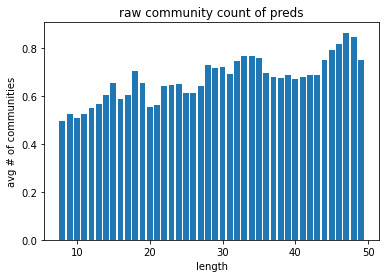

In [276]:
# pred_communities only
hm1 = defaultdict(list)
for i in range(len(pred_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    hm1[len(c2)].append(len(set(c2)))
    
# Convert to percents
for k in hm1:
    hm1[k] = np.mean(hm1[k])
plot_counts(hm1, 'raw community count of preds', xlabel='length', ylabel='avg # of communities')

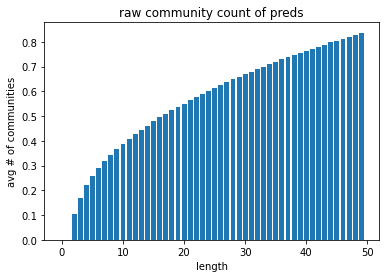

In [279]:
# full pred communities
hm = defaultdict(list)
for pred in predictions:
    c2 = get_communities(pred, community_dict)
    for i in range(len(c2)):
        hm[i].append(len(set(c2[:i])))
for k in hm:
    hm[k] = np.mean(hm[k])
plot_counts(hm, 'raw community count of preds', xlabel='length', ylabel='avg # of communities')

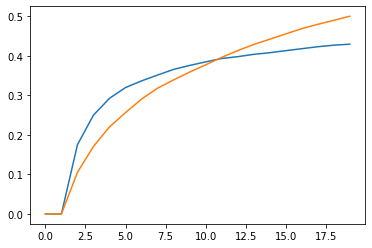

In [284]:
# last k for every train, topk for pred
hm_prev = defaultdict(list)
hm_pred = defaultdict(list)
for i in range(len(prev_comm)):
    c1 = prev_comm[i]
    c2 = get_communities(predictions[i], community_dict)
    for j in range(min(len(c1), 20)):
#         hm_prev[j].append(len(set(c1[:j])))
#         hm_pred[j].append(len(set(c2[:j])))
        hm_prev[j].append(shannon_index(list(reversed(c1))[:j], community_dict))
        hm_pred[j].append(shannon_index(c2[:j], community_dict))
        
for k in hm_prev:
    hm_prev[k] = np.mean(hm_prev[k])
for k in hm_pred:
    hm_pred[k] = np.mean(hm_pred[k])

fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(hm_prev.keys()), [hm_prev[x] for x in sorted(hm_prev.keys())])
ax.plot(sorted(hm_pred.keys()), [hm_pred[x] for x in sorted(hm_pred.keys())])

## Quantifying Diversity Based on Watch History vs Recommendation

In [123]:
def f(c):
    return len(set(c))
    
def f(c):
    hm = Counter(c)
    for val in hm.values():
        if val >= 0.8 * len(c):
            return 1
    return 0

In [124]:
prev_comm_stats = []
pred_comm_stats = []
n = len(prev_comm)
threshold = 0

for i in range(n):
    c1, c2 = prev_comm[i], pred_comm[i]
    if len(c1) < threshold:
        continue
    prev_comm_stats.append(f(c1))
    pred_comm_stats.append(f(c2))

In [125]:
sum(prev_comm_stats)

6063

In [122]:
sum(pred_comm_stats)

8809

# Quantifying Filter-Bubble Based on Combination of Watch History + Recommendation

## Quantify Functions

In [126]:
# Does one of the top 3 predictions belong in a community in the previous history?
def f(prev, pred, threshold=3):
    for comm in pred[:threshold]:
        if comm in prev:
            return 1
    return 0

# Does one of the top-threshold belong in the majority community in the previous history?
def f(prev, pred, threshold=3):
    hm = Counter(prev)
    most_common = max(hm.keys(), key=hm.get)
    
    for comm in pred[:threshold]:
        if comm == most_common:
            return 1
    return 0

# What % of the top-threshold belongs in the most common community in the previous history
def f(prev, pred, threshold=10):
    hm = Counter(prev)
    most_common = max(hm.keys(), key=hm.get)
    
    count = 0
    for comm in pred[:threshold]:
        if comm == most_common:
            count += 1
    return count / threshold

In [127]:
# What percentage of the top-threshold predictions belong in a community in the previous history?
def f(prev, pred, threshold=5):
    count = 0
    for comm in pred[:threshold]:
        if comm in prev:
            count += 1
    return count / threshold

# What percentage of the top-threshold predictions belong in the communities of the last threshold-items in the history?
def f(prev, pred, threshold=10):
    count = 0
    for comm in pred[:threshold]:
        if comm in list(reversed(prev))[:threshold]:
            count += 1
    return count / threshold

## Filter functions

In [128]:
def filter(c):
    hm = Counter(c)
    for val in hm.values():
        if val >= 0.9 * len(c):
            return True
    return False

## This cell actually computes values

In [129]:
counts = []
n = len(prev_comm)
threshold = 0

for i in range(n):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if not filter(c1):
#         continue
    if len(c1) < threshold:
        continue
    counts.append(f(c1,c2))

In [130]:
sum(counts)/len(counts)

0.9331102540834695

In [131]:
sum(counts)/len(counts)

0.9331102540834695

In [ ]:
1 -> 1
12 -> 2
122 -> 3
1223 -> 4

In [ ]:
valid_data

## Extracting filter bubble pts + breaking the filter bubble pts

In [237]:
DIVERSITY_FOLDER = os.path.join(SAVE_FOLDER, "twitch_sequence")